### AS & WITH

![title](./img/as_1.png)
![title](./img/as_2.png)
![title](./img/as_3.png)
![title](./img/as_4.png)

In [1]:
# Pointing the json key file of google cloud service account to local copy
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='key.json'

In [2]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,f5d9499fb93c104c30f2f0a6055787c4e788b0fec8be89...,512,512,1,0,000000000000000160f3b852402569f6a1f1b38cd1a35a...,273029,2013-12-04 13:32:16+00:00,2013-12-01,2,6,978848094.0,978798000.0,False,50094.0,"[{'index': 0, 'spent_transaction_hash': '0608f...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
1,de43728cb2982ab848938d061f55d522e15fe79bb5c3ab...,512,512,1,0,00000000000000003a1260f6a07fa8a9f66bbc89972641...,273014,2013-12-04 11:08:18+00:00,2013-12-01,2,6,633984346.0,633934346.0,False,50000.0,"[{'index': 0, 'spent_transaction_hash': '10e0e...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
2,b9aaa4ab930570f8af4eda306637b9a96b6a5a8bba0b15...,768,768,1,0,0000000000000003696f88dc5eb21e54f25d94938ad562...,277416,2013-12-28 14:48:01+00:00,2013-12-01,4,1,170617369.0,170607369.0,False,10000.0,"[{'index': 0, 'spent_transaction_hash': '91ded...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
3,71863169438b978b5cc812261781a333a2a20b03509601...,768,768,1,0,000000000000000356bdf67fc717f56f065935ec29edd0...,272883,2013-12-03 18:47:25+00:00,2013-12-01,4,2,76686838.0,76586838.0,False,100000.0,"[{'index': 0, 'spent_transaction_hash': 'f9b6b...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
4,eef7f497635bd52bf89393aff898bef8a93dce7058c9ee...,768,768,1,0,000000000000000574f53b20f90356afb560c8e68587f7...,272702,2013-12-02 19:11:15+00:00,2013-12-01,4,4,65856646.0,65816646.0,False,40000.0,"[{'index': 0, 'spent_transaction_hash': '54f5d...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


Since the block_timestamp column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the DATE() command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.


In [3]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


<AxesSubplot:xlabel='trans_date'>

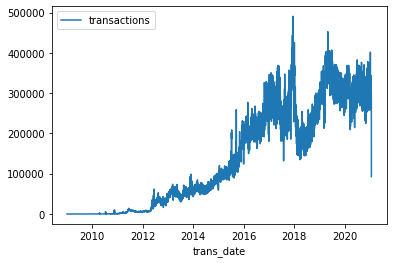

In [5]:
import matplotlib.pyplot as plt

transactions_by_date.set_index('trans_date').plot()

As you can see, **common table expressions (CTEs)** let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.

#### EXERCISE


In [7]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "chicago_taxi_trips" dataset
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

You are curious how much slower traffic moves when traffic volume is high. This involves a few steps.

**1) Find the data**

Before you can access the data, you need to find the table name with the data.

In [9]:
# List all the tables in the "chicago_taxi_trips" dataset
tables = list(client.list_tables(dataset))

for table in tables:
    print(table.table_id)

taxi_trips


In [10]:
# Write the table name as a string below
table_name = 'taxi_trips'

**2) Peek at the data**

In [11]:
#  Construct a reference to the "taxi_trips" table
table_ref = dataset_ref.table('taxi_trips')

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "taxi_trips" table
client.list_rows(table, max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,2aa11ba5fdada1abcd60efeab6983c762d73df77,ecac7e5cafa5aed2b37a75e9888b0eb2a38a9ab5100c94...,2016-03-09 08:45:00+00:00,2016-03-09 08:45:00+00:00,0,0.0,NaN,NaN,NaN,NaN,...,0.0,8.70,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None
1,4db6678c2c1d2458ed01713919651666917ba33e,24a472542efb2433c8f46ed2c0c08c39538e1c41c0178f...,2016-03-08 16:00:00+00:00,2016-03-08 16:00:00+00:00,0,0.0,NaN,NaN,NaN,NaN,...,0.0,12.60,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None
2,2ce0b8e189e622b51b75e3918b0068b3af79d8e8,5a7a34964ad3fbda860c6dbec8eabf560e85d11b7303b1...,2014-10-09 18:00:00+00:00,2014-10-09 18:00:00+00:00,0,0.0,NaN,NaN,NaN,NaN,...,0.0,24.78,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None
3,e04f0c02a3b19d20101030753d58625bf5b72575,ab2b9a0930835b7c79d794179c4e53c68aee771064e532...,2014-11-17 15:00:00+00:00,2014-11-17 15:00:00+00:00,0,0.0,NaN,NaN,NaN,NaN,...,0.0,48.65,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None
4,64db1b5bfaf05da4f699d33f317897a255bb3bca,b968bad5a2daed924a10e8ec4fb35513e060a076c575f7...,2014-09-24 19:15:00+00:00,2014-09-24 19:15:00+00:00,0,0.0,NaN,NaN,NaN,NaN,...,0.0,45.00,Credit Card,T.A.S. - Payment Only,NaN,NaN,None,NaN,NaN,None


Some trips in the top few rows have trip_seconds or trip_miles values of 0. Other location fields have values of None. That is a problem if we want to use those fields.

#### 3) Determine when this data is from

If the data is sufficiently old, we might be careful before assuming the data is still relevant to traffic patterns today. Write a query that counts the number of trips in each year.

Your results should have two columns:

    year - the year of the trips
    num_trips - the number of trips in that year

Hints:

* When using GROUP BY and ORDER BY, you should refer to the columns by the alias year that you set at the top of the SELECT query.

* The SQL code to SELECT the year from trip_start_timestamp is SELECT EXTRACT(YEAR FROM trip_start_timestamp)

* The FROM field can be a little tricky until you are used to it. The format is:

        1. A backick (the symbol `).
        2. The project name. In this case it is bigquery-public-data.
        3. A period.
        4. The dataset name. In this case, it is chicago_taxi_trips.
        5. A period.
        6. The table name. You used this as your answer in 1) Find the data.
        7. A backtick (the symbol `).



In [14]:
# Your code goes here
rides_per_year_query = """
                        SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, 
                               COUNT(1) AS num_trips
                        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                        GROUP BY year
                        ORDER BY year
                       """

# Set up the query (cancel the query if it would use too much of 
# your quota)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_year_query_job =client.query(rides_per_year_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
rides_per_year_result = rides_per_year_query_job.to_dataframe()

# View results
print(rides_per_year_result)

   year  num_trips
0  2013   27217716
1  2014   37395436
2  2015   32385875
3  2016   31759339
4  2017   24988003
5  2018   20732088
6  2019   16477365
7  2020    3889032
8  2021         12


#### 4) Dive slightly deeper

You'd like to take a closer look at rides from 2017. Copy the query you used above in rides_per_year_query into the cell below for rides_per_month_query. Then modify it in two ways:

    Use a WHERE clause to limit the query to data from 2017.
    Modify the query to extract the month rather than the year.



In [18]:
# Your code goes here
rides_per_month_query = """
                        SELECT EXTRACT(MONTH FROM trip_start_timestamp) AS month,                                
                               COUNT(1) AS num_trips
                        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                        WHERE EXTRACT(YEAR FROM trip_start_timestamp) = 2017 
                        GROUP BY month
                        ORDER BY month
                       """

# Set up the query (cancel the query if it would use too much of 
# your quota)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_month_query_job = client.query(rides_per_month_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
rides_per_month_result = rides_per_month_query_job.to_dataframe()

# View results
print(rides_per_month_result)

    month  num_trips
0       1    1972071
1       2    1909802
2       3    2362105
3       4    2194702
4       5    2323386
5       6    2324472
6       7    2054299
7       8    2079861
8       9    1950631
9      10    2141197
10     11    1907997
11     12    1767480


#### 5) Write the query

It's time to step up the sophistication of your queries. Write a query that shows, for each hour of the day in the dataset, the corresponding number of trips and average speed.

Your results should have three columns:

* hour_of_day - sort by this column, which holds the result of extracting the hour from trip_start_timestamp.
* num_trips - the count of the total number of trips in each hour of the day (e.g. how many trips were started between 6AM and 7AM, independent of which day it occurred on).
* avg_mph - the average speed, measured in miles per hour, for trips that started in that hour of the day. Average speed in miles per hour is calculated as 3600 * SUM(trip_miles) / SUM(trip_seconds). (The value 3600 is used to convert from seconds to hours.)

Restrict your query to data meeting the following criteria:

* a trip_start_timestamp between 2017-01-01 and 2017-07-01
* trip_seconds > 0 and trip_miles > 0

You will use a common table expression (CTE) to select just the relevant rides. Because this dataset is very big, this CTE should select only the columns you'll need to create the final output (though you won't actually create those in the CTE -- instead you'll create those in the later SELECT statement below the CTE).

In [23]:
speeds_query = """
               WITH RelevantRides AS
               (
                   SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, 
                          trip_miles, 
                          trip_seconds
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE trip_start_timestamp > '2017-01-01' AND 
                         trip_start_timestamp < '2017-07-01' AND 
                         trip_seconds > 0 AND 
                         trip_miles > 0
               )
               SELECT hour_of_day, 
                      COUNT(1) AS num_trips, 
                      3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
               FROM RelevantRides
               GROUP BY hour_of_day
               ORDER BY hour_of_day
               """

# Set up the query
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
speeds_query_job = client.query(speeds_query, job_config=safe_config) # Your code here

# API request - run the query, and return a pandas DataFrame
speeds_result = speeds_query_job.to_dataframe() # Your code here

# View results
print(speeds_result)

    hour_of_day  num_trips    avg_mph
0             0     319339  20.230524
1             1     266529  18.937621
2             2     210147  18.777070
3             3     159668  20.158048
4             4     122183  26.736014
5             5     119312  30.769172
6             6     182738  24.588313
7             7     358406  17.735967
8             8     541775  15.079892
9             9     565548  16.543882
10           10     525120  18.539614
11           11     594603  18.928379
12           12     622324  17.838745
13           13     630181  17.671089
14           14     622465  16.974239
15           15     640430  15.688418
16           16     701435  14.283888
17           17     756627  12.462955
18           18     768251  13.646810
19           19     701064  16.642882
20           20     598614  19.536777
21           21     552726  20.433874
22           22     501095  19.531374
23           23     399587  19.877046
